In [1]:
import pandas as pd
import numpy as np
import os
import io
import sqlite3
from bs4 import BeautifulSoup

In [2]:
def extract_portfolio(bs_content, contextRef, fund_id):
    
    #Scrape the portfolio information
    port_soup = bs_content.find_all(['CodigoISIN',
                                     'InversionesFinancierasDescripcion',
                                     'InversionesFinancierasPorcentaje'], {'contextRef': [contextRef + '_ia', contextRef + '_ipp']})

    list_ISIN = []
    list_asset = []
    list_description = []
    list_weights_curr = []
    list_weights_past = []

    for i in range(len(port_soup)):
        if port_soup[i].name == 'CodigoISIN' and port_soup[i+1].name == 'InversionesFinancierasDescripcion' and port_soup[i+2].name == 'InversionesFinancierasPorcentaje' and port_soup[i+3].name == 'InversionesFinancierasPorcentaje':

            list_ISIN += [port_soup[i].text]
            i_aux_des = port_soup[i+1].text
            list_asset += [i_aux_des.split('|')[0]]
            list_description += [i_aux_des]
            list_weights_curr += [float(port_soup[i+2].text)/100]
            list_weights_past += [float(port_soup[i+3].text)/100]

    portfolio = pd.DataFrame(data={'ISIN': list_ISIN, 'Activo': list_asset, 'Descripción': list_description,'Peso Actual': list_weights_curr, 'Peso Anterior': list_weights_past})

    other_weights = 1 - portfolio[['Peso Actual', 'Peso Anterior']].sum()
    portfolio = portfolio.append(pd.DataFrame(data={'ISIN': np.nan, 'Activo': 'Tesorería y Otros', 'Descripción': 'Tesorería y Otros', 'Peso Actual': other_weights[0], 'Peso Anterior': other_weights[1]}, index=[0]), ignore_index=True)    
    portfolio['Fund ID'] = fund_id
    
    return portfolio

In [3]:
list_files = os.listdir('Info Pública')
list_files.remove('Portfolios DB')

all_prts = pd.DataFrame(columns=['ISIN', 'Activo', 'Descripción', 'Peso Actual', 'Peso Anterior', 'Fund ID'])

for i_file in list_files:
    
    try:
        #Convert xml format to Beautifulsoup
        content = []
        # Read the XML file        
        with open('Info Pública/' + i_file, 'rb') as file:
            i_bs_content = BeautifulSoup(file.read(), 'xml')        

        #contextRef is an attribute of each file
        #adding '_ia' makes reference to current value and '_ipp' makes reference to past value   
        i_contextRef = i_bs_content.find('context')['id'].replace('_da','')    

        i_port = extract_portfolio(i_bs_content, i_contextRef, i_file.replace('.xml',''))

        all_prts = pd.concat([all_prts, i_port], ignore_index=True)
    
    except:
        continue
    
all_prts.to_pickle('portfolios.pickle')    
all_prts.head(10)

,ISIN,Activo,Descripción,Peso Actual,Peso Anterior,Fund ID
0,ES00000128H5,RFIJA,RFIJA|SPAIN GOVERNMENT|1.30|2026-10-31,0.0006,0.0006,103-1081
1,ES0000012G34,RFIJA,RFIJA|SPAIN GOVERNMENT|1.25|2030-10-31,0.0006,0.0006,103-1081
2,ES0200002055,RFIJA,RFIJA|ADIF ALTA VELOCI|0.55|2030-04-30,0.0020,0.0019,103-1081
3,XS1645495349,RFIJA,RFIJA|CAIXABANK|2.75|2028-07-14,0.0020,0.0020,103-1081
4,ES0265936007,RFIJA,RFIJA|ABANCA CORP BANC|6.12|2029-01-18,0.0020,0.0021,103-1081
5,ES0343307015,RFIJA,RFIJA|KUTXABANK SA|0.50|2024-09-25,0.0019,0.0019,103-1081
6,ES0280907017,RFIJA,RFIJA|UNICAJA BANCO SA|2.88|2029-11-13,0.0017,0.0019,103-1081
7,XS2103013210,RFIJA,RFIJA|RED ELECTRICA FI|0.38|2028-07-24,0.0020,0.0020,103-1081
8,ES0305063010,RFIJA,RFIJA|SIDECU SA|5.00|2025-03-18,0.0021,0.0020,103-1081
9,ES0244251015,RFIJA,RFIJA|IBERCAJA |2.75|2030-07-23,0.0017,0.0018,103-1081


In [7]:
con = sqlite3.connect('Portfolios.db')
cur = con.cursor()
#cur.execute('DROP TABLE IF EXISTS Portfolios')
cur.execute('CREATE TABLE Portfolios (ISIN TEXT, Activo TEXT, Descripción TEXT, Peso_Actual REAL, Peso_Anterior REAL, Fund_ID TEXT)')

records = list(all_prts.to_records(index=False))

cur.executemany('INSERT INTO Portfolios VALUES (?, ?, ?, ?, ?, ?)', records)

con.commit()

con.close()

In [4]:
assets_caract_df = pd.DataFrame(data={'ISIN': all_prts['ISIN'].dropna().unique()})
list_desc = []
list_asset = []
for i_ISIN in list(all_prts['ISIN'].dropna().unique()):
    list_desc += [all_prts.loc[all_prts['ISIN'].isin([i_ISIN])]['Descripción'].values[0]]
    list_asset += [all_prts.loc[all_prts['ISIN'].isin([i_ISIN])]['Activo'].values[0]]
    
assets_caract_df['Descripción'] = list_desc
assets_caract_df['Activo'] = list_asset

assets_caract_df.to_pickle('AssetsFeatures.pickle') 

con = sqlite3.connect('AssetsFeatures.db')
cur = con.cursor()
#cur.execute('DROP TABLE IF EXISTS AssetsFeatures')
cur.execute('CREATE TABLE AssetsFeatures (ISIN TEXT, Descripción TEXT, Activo TEXT)')

records = list(assets_caract_df.to_records(index=False))

cur.executemany('INSERT INTO AssetsFeatures VALUES (?, ?, ?)', records)

con.commit()

con.close()

assets_caract_df.head(10)

,ISIN,Descripción,Activo
0,ES00000128H5,RFIJA|SPAIN GOVERNMENT|1.30|2026-10-31,RFIJA
1,ES0000012G34,RFIJA|SPAIN GOVERNMENT|1.25|2030-10-31,RFIJA
2,ES0200002055,RFIJA|ADIF ALTA VELOCI|0.55|2030-04-30,RFIJA
3,XS1645495349,RFIJA|CAIXABANK|2.75|2028-07-14,RFIJA
4,ES0265936007,RFIJA|ABANCA CORP BANC|6.12|2029-01-18,RFIJA
5,ES0343307015,RFIJA|KUTXABANK SA|0.50|2024-09-25,RFIJA
6,ES0280907017,RFIJA|UNICAJA BANCO SA|2.88|2029-11-13,RFIJA
7,XS2103013210,RFIJA|RED ELECTRICA FI|0.38|2028-07-24,RFIJA
8,ES0305063010,RFIJA|SIDECU SA|5.00|2025-03-18,RFIJA
9,ES0244251015,RFIJA|IBERCAJA |2.75|2030-07-23,RFIJA


In [15]:
all_prts2 = all_prts.dropna().reset_index().drop(columns=['index'],axis=1) #don't consider cash positions
all_prts2['AM Code'] = [i[0] for i in all_prts2['Fund ID'].str.split('-')]
all_prts3 = all_prts2.copy(deep=True)
all_prts2 = all_prts2.loc[all_prts2['Peso Actual']!=0].reset_index().drop(columns=['index'],axis=1) #delete null positions
all_prts3['Diferencias(abs)'] = all_prts3['Peso Actual'] - all_prts3['Peso Anterior']
all_prts3 = all_prts3.loc[all_prts3['Diferencias(abs)']!=0].reset_index().drop(columns=['index'],axis=1) #delete null positions

In [16]:
all_holdings = all_prts2.groupby(['ISIN', 'Fund ID']).sum()['Peso Actual'].unstack().fillna(0)
all_holdings

Fund ID,103-1081,103-1230,103-2269,103-377,103-4290,103-4422,103-502,103-5172,103-5279,103-5330,...,95-5463,95-620,95-621,95-667,98-2187,98-4333,98-4498,98-4672,98-787,98-94
ISIN,,,,,,,,,,,,,,,,,,,,,
,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0225,0.0,...,0.0,0.0,0.0,0.0,0.0313,0.0,0.0,0.0000,0.0,0.0880
,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AN8068571086,0.0128,0.0179,0.0,0.0092,0.0159,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0013,0.0,0.0000
AT000000STR1,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AT00000VIE62,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AT0000383864,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AT0000386115,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AT0000606306,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
AT0000609607,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000


In [24]:
all_holdings_perAM = all_prts2.groupby(['ISIN', 'AM Code']).sum()['Peso Actual'].unstack().fillna(0)
all_holdings_perAM

AM Code,103,105,113,115,12,121,126,128,132,133,...,57,58,61,69,78,84,85,9,95,98
ISIN,,,,,,,,,,,,,,,,,,,,,
,0.0225,0.0000,0.0000,0.0,2.2827,0.0000,0.3192,0.6743,0.0,0.0,...,0.123,0.0000,0.0,0.5768,0.0,0.0000,0.4512,0.0,0.0000,0.1193
,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.5850,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AN8068571086,0.0558,0.0000,0.0034,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0196,0.0004,0.0,0.0000,0.0013
AT000000STR1,0.0000,0.0356,0.0048,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AT00000VIE62,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AT0000383864,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AT0000386115,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AT0000606306,0.0000,0.0036,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0309,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
AT0000609607,0.0000,0.0000,0.0029,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000


In [17]:
top_assets = (all_holdings > 0).sum(axis=1).sort_values(ascending=False).to_frame(name='Count').head(100).reset_index()
top_assets = pd.merge(top_assets, assets_caract_df, how='left', on=['ISIN'])
top_assets = top_assets[['ISIN', 'Activo', 'Descripción', 'Count']].drop_duplicates()
top_assets

,ISIN,Activo,Descripción,Count
0,ES0148396007,ACCIONES,ACCIONES|INDITEX SA,220
1,FR0000120578,ACCIONES,ACCIONES|Sanofi - Synthelabo,191
2,ES0144580Y14,ACCIONES,ACCIONES|IBERDROLA,179
3,ES0173516115,ACCIONES,ACCIONES|REPSOL SA,167
4,FR0000120271,ACCIONES,ACCIONES|TOTAL,156
5,ES0178430E18,ACCIONES,ACCIONES|TELEFONICA,155
6,ES0113900J37,ACCIONES,ACCIONES|BANCO SANTANDER,148
7,DE0007164600,ACCIONES,ACCIONES|SAP - AG,144
8,NL0010273215,ACCIONES,ACCIONES|ASML Holding Nv,141
9,ES0109067019,ACCIONES,ACCIONES|Amadeus,135


In [18]:
#Define a binary representation of stock owernship
holdings_binary = (all_holdings > 0 ).astype(int)
#One thing we can check is correlation among the fund holdings
df_similar_funds = holdings_binary.corr()
df_similar_funds

Fund ID,103-1081,103-1230,103-2269,103-377,103-4290,103-4422,103-502,103-5172,103-5279,103-5330,...,95-5463,95-620,95-621,95-667,98-2187,98-4333,98-4498,98-4672,98-787,98-94
Fund ID,,,,,,,,,,,,,,,,,,,,,
103-1081,1.000000,0.549072,0.446548,0.572835,0.525831,0.107108,0.125611,0.036965,0.037716,0.027543,...,0.016568,-0.004221,0.048087,-0.006340,-0.004919,0.058427,0.063489,0.009922,0.066654,0.003921
103-1230,0.549072,1.000000,0.066848,0.853415,0.800605,0.180669,-0.002357,0.031260,-0.004800,0.050128,...,-0.005221,-0.002546,-0.003266,-0.003824,-0.002967,0.049641,0.053715,0.024804,0.067882,-0.004089
103-2269,0.446548,0.066848,1.000000,0.056785,0.072341,0.377616,0.012245,-0.003982,0.196094,-0.005039,...,0.005429,-0.004713,-0.006045,0.023716,0.020918,0.002277,0.003466,0.015216,-0.005636,0.011640
103-377,0.572835,0.853415,0.056785,1.000000,0.858246,0.157223,0.263838,0.055923,-0.005499,0.043060,...,-0.005982,-0.002917,0.111865,-0.004381,-0.003399,0.073545,0.079394,0.033314,0.099801,-0.004685
103-4290,0.525831,0.800605,0.072341,0.858246,1.000000,0.197275,0.547544,0.052179,-0.005861,0.040023,...,-0.006376,-0.003109,0.249216,-0.004670,-0.003623,0.112468,0.121119,0.018390,0.151409,-0.004994
103-4422,0.107108,0.180669,0.377616,0.157223,0.197275,1.000000,0.040018,-0.001570,-0.003503,-0.001987,...,-0.003810,-0.001858,-0.002383,-0.002791,-0.002165,-0.002942,-0.002746,0.037050,-0.002222,-0.002984
103-502,0.125611,-0.002357,0.012245,0.263838,0.547544,0.040018,1.000000,0.044146,-0.003503,-0.001987,...,-0.003810,-0.001858,0.420025,-0.002791,-0.002165,0.119457,0.128330,-0.003556,0.159523,-0.002984
103-5172,0.036965,0.031260,-0.003982,0.055923,0.052179,-0.001570,0.044146,1.000000,-0.003197,-0.001813,...,-0.003478,-0.001696,-0.002175,-0.002547,-0.001976,-0.002685,-0.002506,-0.003245,-0.002028,-0.002724
103-5279,0.037716,-0.004800,0.196094,-0.005499,-0.005861,-0.003503,-0.003503,-0.003197,1.000000,-0.004046,...,-0.007760,-0.003784,-0.004853,0.057998,0.044743,-0.005992,-0.005592,-0.007241,-0.004524,0.017758


In [25]:
#Define a binary representation of stock owernship
holdings_perAM_binary = (all_holdings_perAM > 0 ).astype(int)
#One thing we can check is correlation among the fund holdings
df_similar_AMs = holdings_perAM_binary.corr()
df_similar_AMs

AM Code,103,105,113,115,12,121,126,128,132,133,...,57,58,61,69,78,84,85,9,95,98
AM Code,,,,,,,,,,,,,,,,,,,,,
103,1.000000,0.024157,0.079018,0.101941,0.122702,0.074185,0.083198,0.108227,0.052820,0.077267,...,0.103251,0.090987,0.075502,0.065026,0.066597,0.109495,0.092823,0.090032,0.072203,0.041074
105,0.024157,1.000000,0.126413,0.182129,0.021477,0.078405,0.087335,0.088709,0.013650,0.068958,...,0.142221,0.020976,0.079548,0.067984,0.092088,0.055174,0.056534,0.041249,0.066989,0.102684
113,0.079018,0.126413,1.000000,0.250180,0.124767,0.130887,0.131110,0.180208,0.080341,0.094068,...,0.166212,0.088014,0.156914,0.070340,0.177175,0.145494,0.197591,0.152942,0.122796,0.180069
115,0.101941,0.182129,0.250180,1.000000,0.147077,0.210184,0.210229,0.270838,0.119046,0.193282,...,0.311776,0.097271,0.223348,0.108262,0.220113,0.158951,0.202875,0.163750,0.169938,0.185930
12,0.122702,0.021477,0.124767,0.147077,1.000000,0.133722,0.132783,0.140628,0.103399,0.034728,...,0.124771,0.115973,0.118869,0.055836,0.080238,0.147289,0.195442,0.136107,0.104853,0.048898
121,0.074185,0.078405,0.130887,0.210184,0.133722,1.000000,0.139016,0.134075,0.091356,0.072261,...,0.134980,0.095318,0.133186,0.069392,0.120925,0.124966,0.197521,0.120753,0.126596,0.152056
126,0.083198,0.087335,0.131110,0.210229,0.132783,0.139016,1.000000,0.176864,0.076413,0.052827,...,0.121792,0.086507,0.122610,0.072877,0.111346,0.144426,0.178345,0.142865,0.140373,0.150793
128,0.108227,0.088709,0.180208,0.270838,0.140628,0.134075,0.176864,1.000000,0.108433,0.108153,...,0.228094,0.077872,0.156355,0.074942,0.163308,0.189889,0.196879,0.148557,0.146120,0.132319
132,0.052820,0.013650,0.080341,0.119046,0.103399,0.091356,0.076413,0.108433,1.000000,0.027869,...,0.095898,0.036008,0.082195,0.086617,0.064162,0.109621,0.098824,0.128997,0.091990,0.031982


In [54]:
all_prts2['103-1081'].values

list_funds = list(all_prts2.columns)
df_similar_funds = pd.DataFrame(data={})
df_similar_funds['Fund ID'] = list_funds

for i_fund in list_funds:
    i_list = []
    for j_fund in list_funds:
        #Calculate the cosine similarity between 2 portfolios
        i_list += [np.dot(all_prts2[i_fund].values, all_prts2[j_fund].values)/(np.linalg.norm(all_prts2[i_fund].values)*np.linalg.norm(all_prts2[j_fund].values))]
    df_similar_funds[i_fund] = i_list    
df_similar_funds

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


,Fund ID,103-1081,103-1230,103-2269,103-377,103-4290,103-4422,103-502,103-5172,103-5279,...,95-5463,95-620,95-621,95-667,98-2187,98-4333,98-4498,98-4672,98-787,98-94
0,103-1081,1.000000,0.826612,0.241525,0.825023,0.808318,0.230649,0.098791,0.041268,0.019931,...,0.003596,0.000000,0.010018,0.000000,0.000000,0.017228,0.040705,0.005732,0.065436,0.000269
1,103-1230,0.826612,1.000000,0.158090,0.869222,0.873884,0.229784,0.000000,0.025829,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012567,0.029731,0.005761,0.050011,0.000000
2,103-2269,0.241525,0.158090,1.000000,0.163604,0.174780,0.547407,0.027224,0.000000,0.306272,...,0.004455,0.000000,0.000000,0.028397,0.004090,0.001063,0.002184,0.047213,0.000000,0.000967
3,103-377,0.825023,0.869222,0.163604,1.000000,0.912620,0.234672,0.068465,0.033308,0.000000,...,0.000000,0.000000,0.007930,0.000000,0.000000,0.010962,0.026319,0.030222,0.043666,0.000000
4,103-4290,0.808318,0.873884,0.174780,0.912620,1.000000,0.248436,0.187220,0.038854,0.000000,...,0.000000,0.000000,0.072421,0.000000,0.000000,0.014118,0.033795,0.005768,0.057494,0.000000
5,103-4422,0.230649,0.229784,0.547407,0.234672,0.248436,1.000000,0.046916,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012941,0.000000,0.000000
6,103-502,0.098791,0.000000,0.027224,0.068465,0.187220,0.046916,1.000000,0.055306,0.000000,...,0.000000,0.000000,0.244824,0.000000,0.000000,0.020742,0.049609,0.000000,0.080764,0.000000
7,103-5172,0.041268,0.025829,0.000000,0.033308,0.038854,0.000000,0.055306,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,103-5279,0.019931,0.000000,0.306272,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.020645,0.041309,0.000000,0.000000,0.000000,0.000000,0.169713
9,103-5330,0.033150,0.038318,0.000000,0.031254,0.042919,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


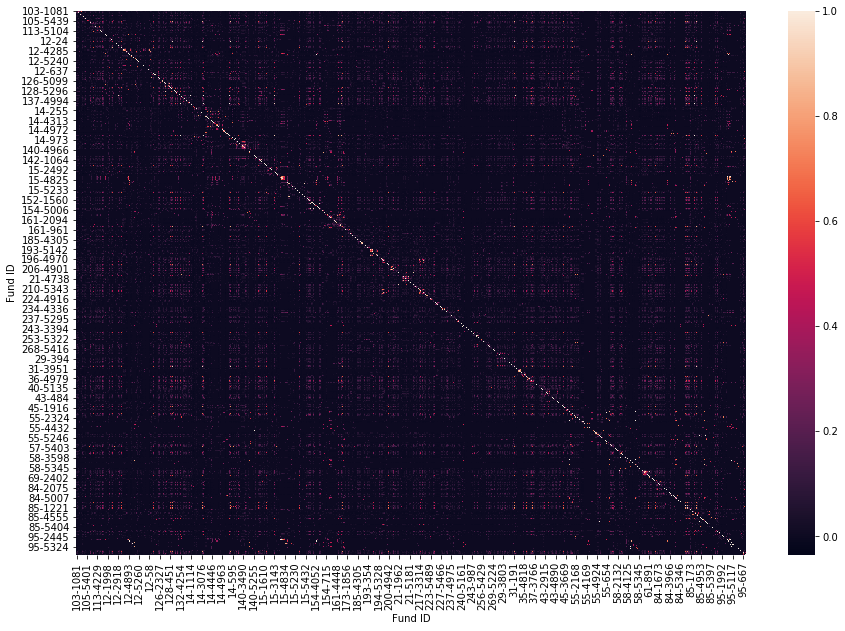

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_similar_funds, ax=ax)

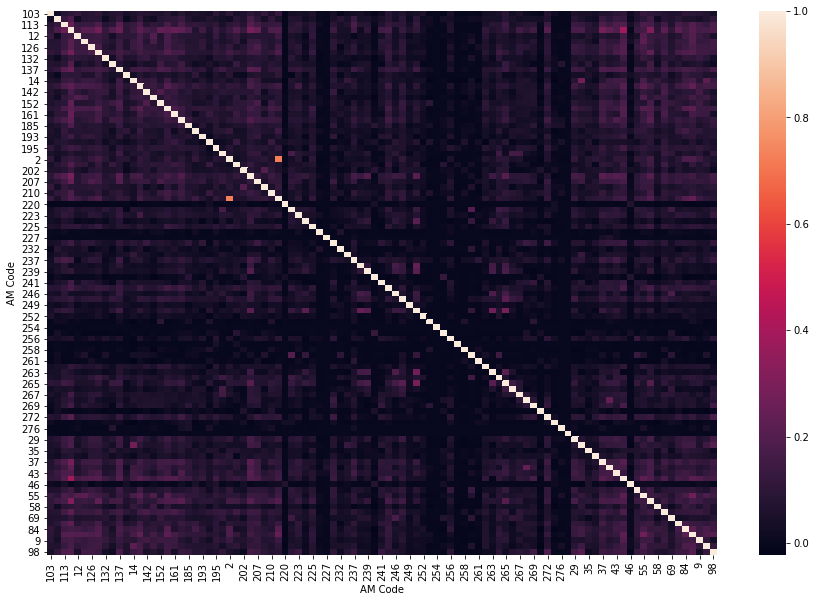

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_similar_AMs, ax=ax)

In [32]:
df_similar_AMs['12']

AM Code
103    0.122702
105    0.021477
113    0.124767
115    0.147077
12     1.000000
121    0.133722
126    0.132783
128    0.140628
132    0.103399
133    0.034728
137    0.106414
139    0.099104
14     0.098584
140    0.163382
142    0.109165
15     0.194937
152    0.072740
154    0.170931
161    0.110412
173    0.083661
185    0.087452
190    0.079649
193    0.072711
194    0.046707
195    0.127165
196    0.051692
2      0.095999
200    0.114736
202    0.054839
206    0.080629
         ...   
266    0.022575
267    0.051378
268    0.037903
269    0.039696
271   -0.004149
272    0.069213
274    0.006093
276    0.013252
277   -0.003253
29     0.050047
31     0.032642
35     0.076418
36     0.032142
37     0.078821
40     0.059668
43     0.068433
45     0.159942
46     0.017902
49     0.052363
55     0.207837
57     0.124771
58     0.115973
61     0.118869
69     0.055836
78     0.080238
84     0.147289
85     0.195442
9      0.136107
95     0.104853
98     0.048898
Name: 12, Length

In [36]:
all_prts2.groupby(['ISIN', 'AM Code']).sum()['Peso Actual'].unstack().fillna(0).reset_index()

AM Code,ISIN,103,105,113,115,12,121,126,128,132,...,57,58,61,69,78,84,85,9,95,98
0,,0.0225,0.0000,0.0000,0.0,2.2827,0.0,0.3192,0.6743,0.0,...,0.123,0.0000,0.0,0.5768,0.0,0.0000,0.4512,0.0,0.0000,0.1193
1,,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.5850,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
2,AN8068571086,0.0558,0.0000,0.0034,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0196,0.0004,0.0,0.0000,0.0013
3,ANN4327C1220,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
4,ARP125991090,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
5,AT000000STR1,0.0000,0.0356,0.0048,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
6,AT00000VIE62,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
7,AT0000383864,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
8,AT0000386115,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
9,AT0000606306,0.0000,0.0036,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,...,0.000,0.0309,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000


In [37]:
all_prts3.groupby(['ISIN', 'Fund ID']).sum()['Diferencias(abs)'].unstack().fillna(0).reset_index()

Fund ID,ISIN,103-1081,103-1230,103-2269,103-377,103-4290,103-4422,103-502,103-5172,103-5279,...,95-5463,95-620,95-621,95-667,98-2187,98-4333,98-4498,98-4672,98-787,98-94
0,,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0048,0.0,0.0,0.0000,0.0,-0.0044
1,,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
2,AN8068571086,0.0058,0.0077,0.0,-0.0069,0.0072,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,-0.0001,0.0,0.0000
3,ANN4327C1220,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
4,ARP125991090,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
5,AT000000STR1,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
6,AT00000VIE62,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
7,AT0000383864,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
8,AT0000386115,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000
9,AT0000606306,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000


In [38]:
all_prts3.groupby(['ISIN', 'AM Code']).sum()['Diferencias(abs)'].unstack().fillna(0).reset_index()

AM Code,ISIN,103,105,113,115,12,121,126,128,132,...,57,58,61,69,78,84,85,9,95,98
0,,0.0000,0.0000,0.0000,0.0,-0.3934,0.0,0.1149,0.011,-0.182,...,-0.0801,0.0000,0.0,0.0298,0.0,0.0000,0.1496,0.0,0.0000,0.0004
1,,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.5617,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
2,AN8068571086,0.0138,0.0000,0.0034,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,-0.0007,0.0000,0.0,0.0000,-0.0001
3,ANN4327C1220,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
4,ARP125991090,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
5,AT000000STR1,0.0000,-0.0081,0.0048,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
6,AT00000VIE62,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
7,AT0000383864,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
8,AT0000386115,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000
9,AT0000606306,0.0000,0.0036,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.000,...,0.0000,0.0222,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000


In [25]:
bs_content.find_all('Patrimonio', {'contextRef': 'FIM_S22020_V-61518734_ia'})

[<iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">13194993</iic-com:Patrimonio>,
 <iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">14572672</iic-com:Patrimonio>,
 <iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">1309422</iic-com:Patrimonio>,
 <iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">951779</iic-com:Patrimonio>,
 <iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">8665032</iic-com:Patrimonio>,
 <iic-com:Patrimonio contextRef="FIM_S22020_V-61518734_ia" decimals="0" unitRef="euro">3294043</iic-com:Patrimonio>]

In [26]:
float(bs_content.find_all('Patrimonio')[0].text)

13194993.0

In [8]:
print(bs_content.find_all('InformacionPoliticaRemuneracion')[0].text)

Mediolanum GestiÃ³n, SGIIC, S.A como sociedad perteneciente al Grupo Bancario Mediolanum, sigue las directrices emanadas por este grupo en materia de PolÃ­ticas de RemuneraciÃ³n e IncentivaciÃ³n y cuenta con una polÃ­tica de remuneraciÃ³n propia aprobada por el Consejo de AdministraciÃ³n de Mediolanum GestiÃ³n, que ademÃ¡s incorpora los requerimientos de la normativa tanto espaÃ±ola como europea en relaciÃ³n a la remuneraciÃ³n de las gestoras de IIC. La polÃ­tica es compatible con una gestiÃ³n adecuada y eficaz de los riesgos y con la estrategia empresarial, los objetivos, los valores y los intereses a largo plazo propios y de las IIC que gestiona.



La polÃ­tica se revisa de forma anual y se realizan las modificaciones oportunas. En la revisiÃ³n de 2020 respecto el aÃ±o anterior, se han modificado 2 elementos de la polÃ­tica: 



1.	Los resultados de desempeÃ±o logrados por el Grupo confirman la consolidaciÃ³n del modelo de negocio y los sistemas de remuneraciÃ³n variable, con las co